In [1]:
import os
import pandas as pd
import numpy as np

def load_gripper_and_obj_trajectories(base_dir, i = 0, triangulation = 'leastereo'):
    '''
    This function reads the servo file to find the start and the end of the ith. action in the demonstrations.
    The corresponding ndi file and object pose file will be loaded and the ith. action trajectory from start 
    to the end will be ouputed as dictionaries.
    
    Parameters
    ----------
    base_dir: string
        The path to the folder where all the demonstrations are saved.
    i: int 
        The index of the action that will be outputed.
    triangulation: string
        'leastereo' or 'dlc3d', which corresponds to which triangulation method is used to get the
        
    Returns
    -------
    gripper_traj: dict
        A dictionary whose keys are the demonstraions' ids. 
        The values are the dataframes of the corersponding
        demonstration's gripper trajectory data in ndi reference frame.
    obj_traj: dict
        A dictionary whose keys are the demonstraions' ids. The values are the dataframes of the corersponding
        demonstration's objects' pose trajectories in camera reference frame.
    '''
    demos = os.listdir(base_dir)
    gripper_trajs = {}
    obj_trajs = {}
    for demo in demos:
        demo_dir = os.path.join(base_dir, demo)
        root, dirs, files = next(os.walk(demo_dir))
        if demo == 'transformations':
            continue
        for f in files:
            if 'Servo' in f:
                servo_file = os.path.join(demo_dir, f)
            elif 'NDI' in f:
                ndi_file = os.path.join(demo_dir, f)
        obj_pose_file = os.path.join(demo_dir, triangulation + '_old', 'obj_pose_trajectory.h5')
        # Open servo file to find the start and end of an action
        with open(servo_file, 'r') as f:
            lines = f.readlines()
            t_start = float(lines[1 + i].split(',')[0])
            t_end = float(lines[2 + i].split(',')[0])
        # Open NDI file and extract the parts corresponding to the queried action
        df_temp1 = pd.read_csv(ndi_file)
        duration = t_end - t_start
        idx_start = df_temp1['Time'].sub(t_start).abs().idxmin()
        idx_end = df_temp1['Time'].sub(t_end).abs().idxmin()
        df_gripper = df_temp1[idx_start: idx_end].copy()
        # Set the time to start from 0
        df_gripper.loc[:, 'Time'] = df_gripper.loc[:, 'Time'] - df_gripper.loc[:, 'Time'].iloc[0]
        gripper_trajs[demo] = df_gripper
        
        df_temp2 = pd.read_hdf(obj_pose_file)
        idx_start_obj = int(len(df_temp2) * idx_start / len(df_temp1))
        idx_end_obj = int(len(df_temp2) * idx_end / len(df_temp1))
        df_obj = df_temp2[idx_start_obj: idx_end_obj].reset_index(drop=True)
        df_obj.loc[:,'Time'] = np.arange(len(df_obj))/len(df_obj)*duration
        obj_trajs[demo] = df_obj.drop('time_stamp', axis = 1, level = 'individuals')
    return gripper_trajs, obj_trajs

base_dir = '/home/luke/Desktop/project/Process_data/postprocessed/2022-05-26'
gripper_trajs_in_ndi, obj_trajs_in_camera = load_gripper_and_obj_trajectories(base_dir)

# Convert the object's pose trajectories from camera frame to NDI reference frames

In [2]:
import numpy as np
import pickle

def homogenous_position(vect):
    temp = np.array(vect)
    ones = np.ones(temp.shape[0])
    return np.c_[temp, ones]
    
def convert_from_frame1_to_frame2(df1, H):
    '''
    This function will convert the coordinates in the first frame to the second reference frame
    
    Parameters
    ----------
    df_1: Dataframe
        The dataframe that contains the objects trajectory in first reference frame
    H: 4 by 4 ndarray
        The homogenous transformation that will convert points from first frame to second frame
    Output:
    df2: Dataframe
        The objects trajectory in the second reference frame
    '''
    # Get the individuals
    individuals = df1.columns.get_level_values('individuals').unique()
    
    df2 = df1.copy()
    # Multiply the coords from camera by 10 becuase it is in cm but NDI is in mm. Then do rotation and translation
    for individual in individuals:
        if individual == 'Time':
            continue
        temp = homogenous_position(df1[individual][['x', 'y', 'z']].to_numpy())
        coords_converted = (H @ temp.T).T[:, :3] 
        df2.loc[:, (individual, ['x', 'y', 'z'])] = coords_converted
    return df2

dirname = '/home/luke/Desktop/project/Process_data/postprocessed/2022-05-26/transformations/leastereo'
with open(os.path.join(dirname, 'camera_to_ndi.pickle'), "rb") as f:
    camera_to_ndi = pickle.load(f)

obj_trajs_in_ndi = {}
for demo in obj_trajs_in_camera:
    traj = obj_trajs_in_camera[demo]
    obj_trajs_in_ndi[demo] = convert_from_frame1_to_frame2(traj, camera_to_ndi)

# Convert the gripper trajectories from NDI frame to object frame

In [3]:
# Assume all the objects have the same orientation with ndi and only care about the translation
individuals = ['pitcher', 'teabag1', 'teabag2', 'cup', 'tap']
gripper_trajs_in_obj = {individual :{} for individual in individuals}
n_points = 20
for individual in individuals:
    for demo in gripper_trajs_in_ndi:
        gripper_traj_in_ndi = gripper_trajs_in_ndi[demo]
        obj_traj_in_ndi = obj_trajs_in_ndi[demo]
        translation = obj_traj_in_ndi[individual][['x', 'y', 'z']].iloc[:n_points].median(axis = 0).to_numpy()
        gripper_traj_in_obj = gripper_traj_in_ndi.copy()
        gripper_traj_in_obj[['x', 'y', 'z']] = gripper_traj_in_obj[['x', 'y', 'z']] - translation
        gripper_trajs_in_obj[individual][demo] = gripper_traj_in_obj

# Plot the trajectories

<IPython.core.display.Javascript object>


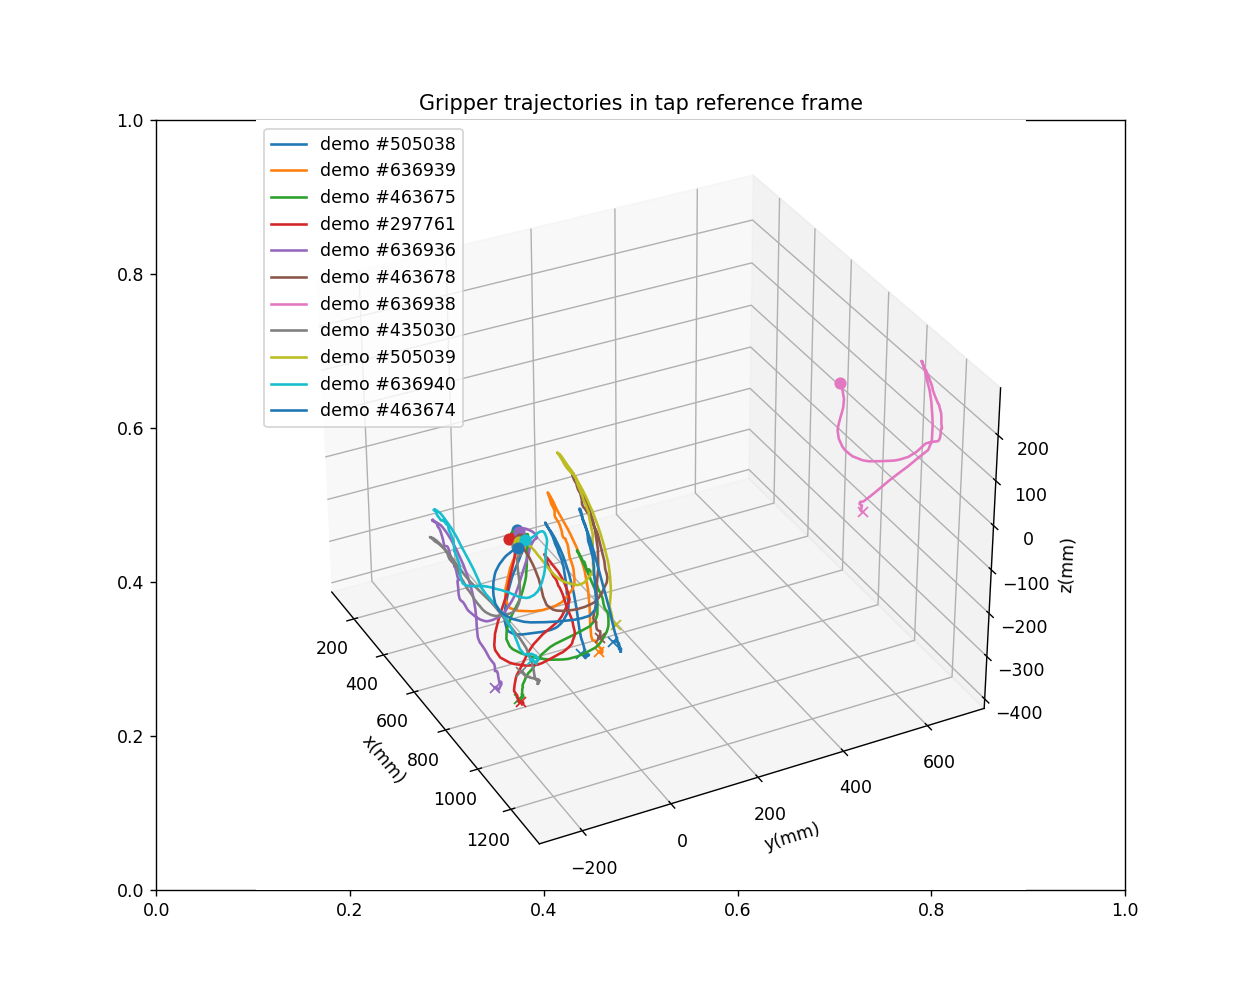

In [12]:
import robpy.full_promp as promp
import robpy.utils as utils
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook


fig,ax = plt.subplots(1,1, figsize = (10,8))

individual = 'tap'

data = gripper_trajs_in_obj
ax = plt.axes(projection='3d')
for demo in data[individual]:
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()


# Filter data

In [6]:
from scipy import ndimage
# A Gaussian filter is used to get the trajectories smoother so that it is easier to learn
gripper_trajs_in_obj_filtered = {individual :{} for individual in individuals}
sigma = 5
sigma = [sigma, 0]
for individual in individuals:
    for demo in gripper_trajs_in_obj[individual]:
        q = gripper_trajs_in_obj[individual][demo].loc[:, ['x', 'y', 'z']]
        q_filtered = ndimage.gaussian_filter(q, sigma = sigma)
        temp = gripper_trajs_in_obj[individual][demo].copy()
        temp.loc[:, ['x', 'y', 'z']] = q_filtered
        gripper_trajs_in_obj_filtered[individual][demo] = temp
        


# Plot filtered trajectories with bad demos removed

<IPython.core.display.Javascript object>


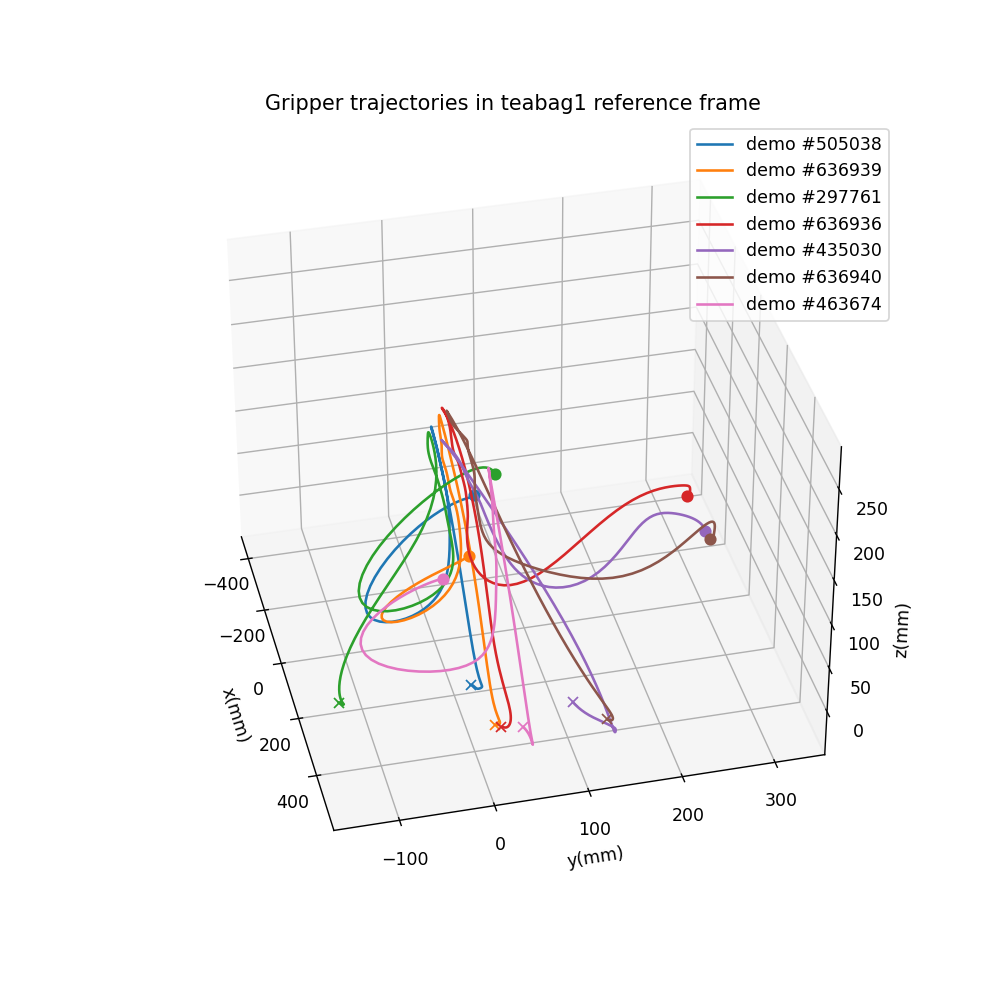

In [14]:
individual = 'teabag1'
bad_demos = ['505039', '463678', '636938', '463675']

'''
teabag1 is incorrectly labeld for demos: '505039', '463678'
something is wrong with tap: '636938'
something is wrong with pitcher: '463675'
'''
plt.figure(figsize = (8,8))
ax = plt.axes(projection='3d')

data = gripper_trajs_in_obj_filtered
for demo in data[individual]:
    if demo in bad_demos:
        continue
    df = data[individual][demo]
    line = ax.plot(df.loc[:,'z'], df.loc[:,'y'], -df.loc[:,'x'], label = f'demo #{demo}');
    ax.plot(df.loc[:,'z'].iloc[0], df.loc[:,'y'].iloc[0], -df.loc[:,'x'].iloc[0],  'o', color = line[0].get_color())
    ax.plot(df.loc[:,'z'].iloc[-1], df.loc[:,'y'].iloc[-1], -df.loc[:,'x'].iloc[-1], 'x', color = line[0].get_color())
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Gripper trajectories in {individual} reference frame')
plt.legend()    
plt.show()

# Train ProbMPs

In [19]:
import random

sig = 0.035 # The standard deviation of the Gaussian functions
# Define the basis functions
full_basis = {
        'conf': [
                {"type": "sqexp", "nparams": 22, "conf": {"dim": 21}},
            {"type": "poly", "nparams": 0, "conf": {"order": 1}},
            {"type": "poly", "nparams": 0, "conf": {"order": 2}},
            {"type": "poly", "nparams": 0, "conf": {"order": 3}}
            ],
        'params': [np.log(sig),0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65
                   ,0.7,0.75,0.8,0.85,0.9,0.95,1]
        }

individuals = ['pitcher', 'teabag1', 'cup', 'tap', 'teabag2']
# Each individual will have its own promp model
promps = {individual : promp.FullProMP(basis=full_basis) for individual in individuals}


#3) Train ProMP with NIW prior on the covariance matrix (as described in the paper)

gripper_trajs_in_obj_filtered_train = {individual: {'coords':[], 'time':[]} for individual in individuals}
demos = [demo for demo in list(gripper_trajs_in_ndi.keys())if demo not in bad_demos]
train_demos = random.sample(demos, k=5)

for individual in individuals:
    for d in train_demos:
        t = gripper_trajs_in_obj_filtered[individual][d]['Time'].to_numpy().flatten()
        t = t / t[-1]
        gripper_trajs_in_obj_filtered_train[individual]['coords'].append(
            gripper_trajs_in_obj_filtered[individual][d].loc[:,['x', 'y','z']].to_numpy())
        gripper_trajs_in_obj_filtered_train[individual]['time'].append(t)

dof = 3
dim_basis_fun = 30
inv_whis_mean = lambda v, Sigma: 9e-1*utils.make_block_diag(Sigma, dof) + 1e-1*np.eye(dof*dim_basis_fun)
prior_Sigma_w = {'v':dim_basis_fun*dof, 'mean_cov_mle': inv_whis_mean}
for individual in individuals:
    Q = gripper_trajs_in_obj_filtered_train[individual]['coords']
    times = gripper_trajs_in_obj_filtered_train[individual]['time']
    train_summary = promps[individual].train(times, q = Q, max_iter=30, prior_Sigma_w=prior_Sigma_w,
            print_inner_lb=True)

lb(mu_w)= -4082711.4724941067
lb(Sigma_w)= -42985.18428509381
lb(Sigma_y)= -16269.466265656181
lb(mu_w)= -17612.445153551445
lb(Sigma_w)= -16817.65987797834
lb(Sigma_y)= -16598.07192340271
lb(mu_w)= -17746.688589620957
lb(Sigma_w)= -16527.661628493617
lb(Sigma_y)= -16464.19713631537
lb(mu_w)= -17376.82336201958
lb(Sigma_w)= -16141.864414732945
lb(Sigma_y)= -16094.901867088112
lb(mu_w)= -16872.21141439347
lb(Sigma_w)= -15684.694474594518
lb(Sigma_y)= -15654.438833876553
lb(mu_w)= -16296.505314168906
lb(Sigma_w)= -15249.191520207689
lb(Sigma_y)= -15231.296811597751
lb(mu_w)= -15725.664774906534
lb(Sigma_w)= -14873.400930162534
lb(Sigma_y)= -14862.86291801691
lb(mu_w)= -15223.649653844226
lb(Sigma_w)= -14563.696447679198
lb(Sigma_y)= -14557.410559810256
lb(mu_w)= -14813.86294930402
lb(Sigma_w)= -14314.149563749232
lb(Sigma_y)= -14310.337081011276
lb(mu_w)= -14491.61800595236
lb(Sigma_w)= -14115.062349896752
lb(Sigma_y)= -14112.698698679615
lb(mu_w)= -14241.740255236551
lb(Sigma_w)= -13956

lb(Sigma_y)= -13521.474653140767
lb(mu_w)= -13525.288777713757
lb(Sigma_w)= -13512.845231419858
lb(Sigma_y)= -13512.838223377687
lb(mu_w)= -13516.471093790904
lb(Sigma_w)= -13505.107877657982
lb(Sigma_y)= -13505.102360761723
lb(mu_w)= -4077235.288216836
lb(Sigma_w)= -44493.589579885134
lb(Sigma_y)= -16349.042748975731
lb(mu_w)= -17728.282739393602
lb(Sigma_w)= -16928.22021706223
lb(Sigma_y)= -16724.474458144174
lb(mu_w)= -17804.748224061415
lb(Sigma_w)= -16708.881719001263
lb(Sigma_y)= -16651.232302102246
lb(mu_w)= -17477.878668084617
lb(Sigma_w)= -16380.526036472456
lb(Sigma_y)= -16339.813331403537
lb(mu_w)= -17033.513722657186
lb(Sigma_w)= -15971.865060689703
lb(Sigma_y)= -15944.13466768689
lb(mu_w)= -16521.112143276598
lb(Sigma_w)= -15565.07916423279
lb(Sigma_y)= -15547.584038361116
lb(mu_w)= -16001.496178142505
lb(Sigma_w)= -15201.017354079802
lb(Sigma_y)= -15190.231672132379
lb(mu_w)= -15528.792978903717
lb(Sigma_w)= -14892.015539453902
lb(Sigma_y)= -14885.336421375983
lb(mu_w)= -

# Plot samples after training

<IPython.core.display.Javascript object>


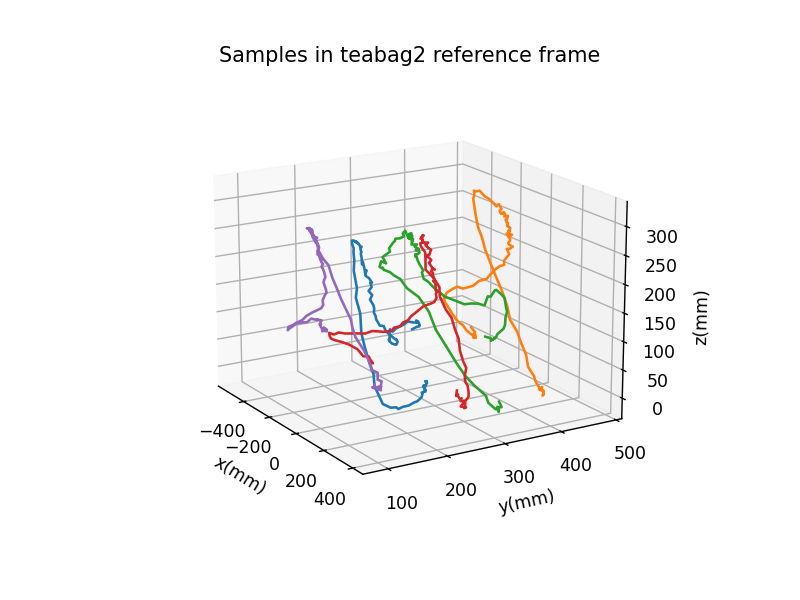

In [21]:
#4) Plot some samples from the learned ProMP and conditioned ProMP

n_samples = 5 # Number of samples to draw
plot_dof = 1 # Degree of freedom to plot
sample_time = [np.linspace(0,1,100) for i in range(n_samples)]

#4.1) Make some samples from the unconditioned ProMP
individual = 'teabag2'
promp_samples = promps[individual].sample(sample_time)
plt.figure()
ax = plt.axes(projection='3d')
for t,q in zip(sample_time, promp_samples):
    if q.shape[1] == 1:
        plt.plot(np.array(t) - t[0],q[:,0])
    else:
        ax.plot(q[:,2], q[:,1], - q[:,0])
        ax.set_xlabel('x(mm)')
        ax.set_ylabel('y(mm)')
        ax.set_zlabel('z(mm)')
        ax.set_title(f'Samples in {individual} reference frame')
plt.show()

# Test on unseen trajectories and compare the distance at key points

<IPython.core.display.Javascript object>


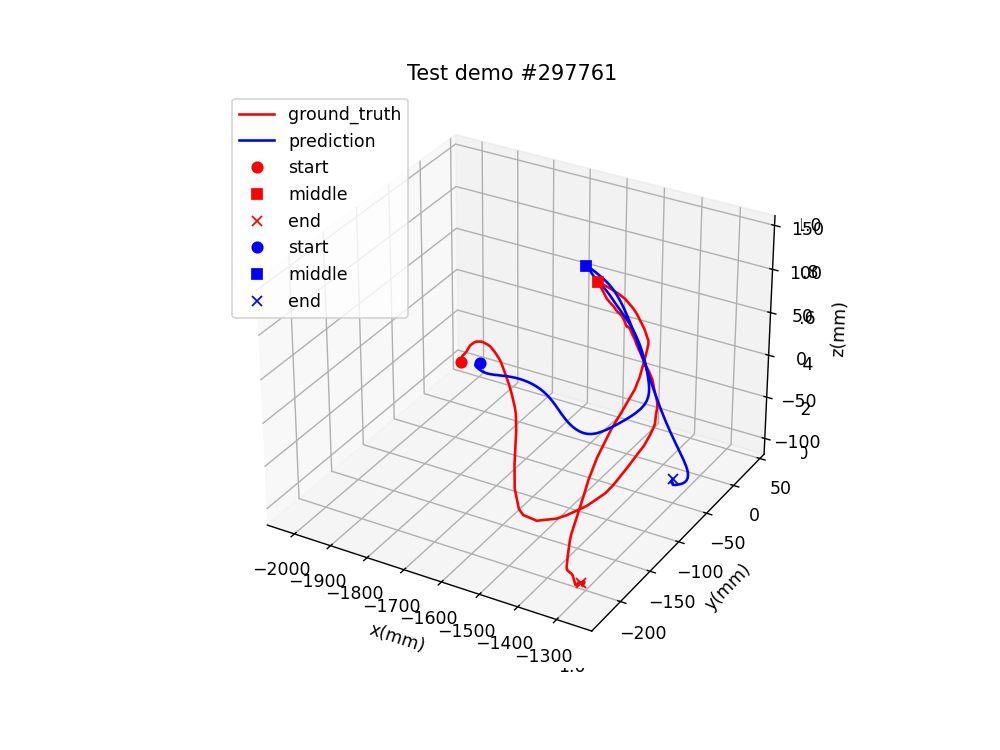

This distance at the start point is 51.289724546061045 mm
This distance at the middle point is 62.21768222664639 mm
This distance at the end point is 186.21659713882477 mm


<IPython.core.display.Javascript object>


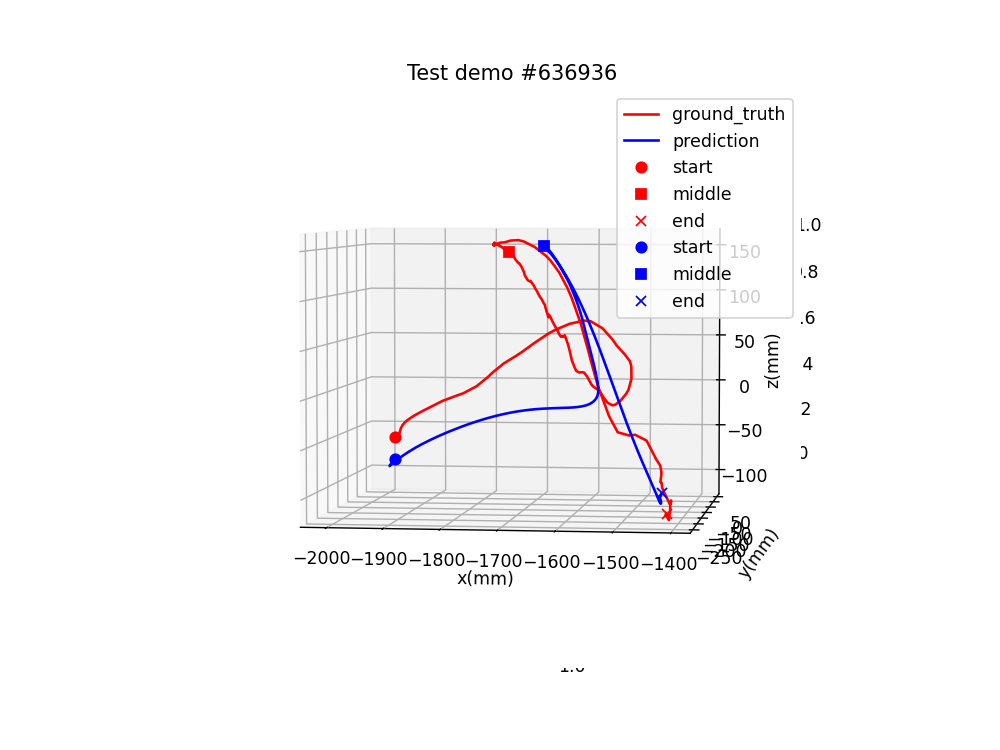

This distance at the start point is 25.258850854911863 mm
This distance at the middle point is 60.04056757437772 mm
This distance at the end point is 82.04551917128833 mm


In [22]:
def get_mean_cov_hats(ref_means, ref_covs, min_len=None):
    sigma_hats, ref_pts = [], len(ref_means)
    if not min_len:
        min_len = min([len(r) for r in ref_means])
    # solve for global covariance
    for p in range(min_len):
        covs = [cov[p] for cov in ref_covs]
        inv_sum = np.linalg.inv(covs[0])
        for ref in range(1, ref_pts):
            inv_sum = inv_sum + np.linalg.inv(covs[ref])
        sigma_hat = np.linalg.inv(inv_sum)
        sigma_hats.append(sigma_hat)

    mean_hats = []
    for p in range(min_len):
        mean_w_sum = np.matmul(np.linalg.inv(ref_covs[0][p]), ref_means[0][p])
        for ref in range(1, ref_pts):
            mean_w_sum = mean_w_sum + np.matmul(np.linalg.inv(ref_covs[ref][p]), ref_means[ref][p])
        mean_hats.append(np.matmul(sigma_hats[p], mean_w_sum))
    return np.array(mean_hats), np.array(sigma_hats)

test_demos = [demo for demo in demos if demo not in train_demos]

for demo in test_demos:
    ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z']].to_numpy()
    t = np.linspace(0,1, ground_truth.shape[0])

    means_objs_global = []
    covs_objs_global = []
    for individual in individuals:
        mean, cov = promps[individual].marginal_w(t)
        translation = obj_trajs_in_ndi[demo][individual][['x', 'y', 'z']].iloc[:n_points].median(axis = 0).to_numpy()
        mean_global = mean + translation
        
        means_objs_global.append(mean_global)
        covs_objs_global.append(cov)

    mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
    mid_ind = int(0.62 * len(mean_hats))
    
    plt.figure(figsize = (8,6))
    ax = plt.axes(projection='3d')
    ax = plt.axes(projection='3d')
    ax.plot(ground_truth[:,2], ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
    ax.plot(mean_hats[:,2], mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
    ax.plot(ground_truth[0,2], ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
    ax.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
    ax.plot(ground_truth[-1,2], ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
    ax.plot(mean_hats[0,2], mean_hats[0,1], -mean_hats[0,0],'bo', label = 'start')
    ax.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], -mean_hats[mid_ind,0],'bs', label = 'middle')
    ax.plot(mean_hats[-1,2], mean_hats[-1,1], -mean_hats[-1,0],'bx', label = 'end')
    ax.set_xlabel('x(mm)')
    ax.set_ylabel('y(mm)')
    ax.set_zlabel('z(mm)')
    ax.set_title(f'Test demo #{demo}')
    dist_mid = np.linalg.norm(ground_truth[mid_ind,:] - mean_hats[mid_ind,:])
    dist_start = np.linalg.norm(ground_truth[0,:] - mean_hats[0,:])
    dist_end = np.linalg.norm(ground_truth[-1,:] - mean_hats[-1,:])
    print(f'This distance at the start point is {dist_start} mm')
    print(f'This distance at the middle point is {dist_mid} mm')
    print(f'This distance at the end point is {dist_end} mm')
    plt.legend()
#     plt.show()


Demo # 505038


<IPython.core.display.Javascript object>


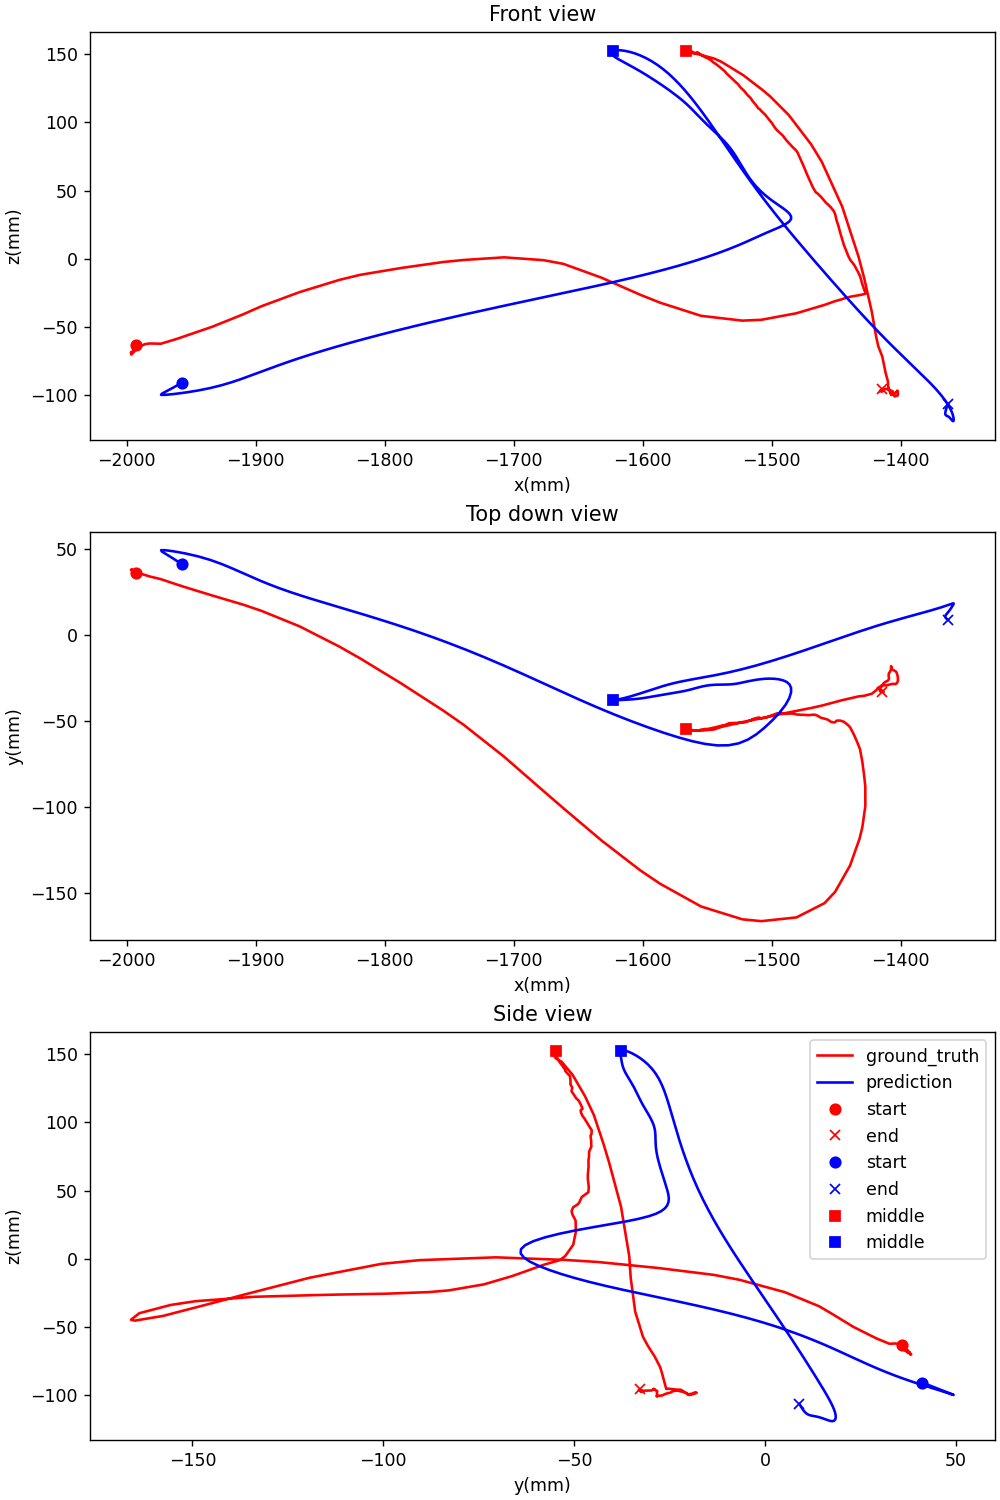

In [18]:
demo = test_demos[0]
print(f'Demo # {demo}')
ground_truth = gripper_trajs_in_ndi[demo][['x', 'y', 'z']].to_numpy()
t = np.linspace(0,1, ground_truth.shape[0])

means_objs_global = []
covs_objs_global = []
for individual in individuals:
    mean, cov = promps[individual].marginal_w(t)
    translation = obj_trajs_in_ndi[demo][individual][['x', 'y', 'z']].iloc[:n_points].median(axis = 0).to_numpy()
    mean_global = mean + translation
    means_objs_global.append(mean_global)
    covs_objs_global.append(cov)

mean_hats, sigma_hats = get_mean_cov_hats(means_objs_global, covs_objs_global)
mid_ind = int(0.62 * len(mean_hats))

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,12), constrained_layout = True)
ax1.plot(ground_truth[:,2], -ground_truth[:,0],'r', label = 'ground_truth')
ax1.plot(mean_hats[:,2], -mean_hats[:,0], 'b', label = 'prediction')
ax1.plot(ground_truth[mid_ind,2], -ground_truth[mid_ind,0],'rs', label = 'middle')
ax1.plot(mean_hats[mid_ind,2], -mean_hats[mid_ind,0], 'bs', label = 'middle')
ax1.plot( ground_truth[0,2],-ground_truth[0,0],'ro', label = 'start')
ax1.plot( ground_truth[-1,2],-ground_truth[-1,0],'rx', label = 'end')
ax1.plot( mean_hats[0,2],-mean_hats[0,0],'bo', label = 'start')
ax1.plot( mean_hats[-1,2],-mean_hats[-1,0],'bx', label = 'end')
ax1.set_xlabel('x(mm)')
ax1.set_ylabel('z(mm)')
ax1.set_title('Front view')

ax2.plot(ground_truth[:,2], ground_truth[:,1],'r', label = 'ground_truth')
ax2.plot(mean_hats[:,2], mean_hats[:,1], 'b', label = 'prediction')
ax2.plot(ground_truth[0,2], ground_truth[0,1],'ro', label = 'start')
ax2.plot(ground_truth[-1,2], ground_truth[-1,1],'rx', label = 'end')
ax2.plot( mean_hats[0,2],mean_hats[0,1],'bo', label = 'start')
ax2.plot( mean_hats[-1,2],mean_hats[-1,1],'bx', label = 'end')
ax2.plot(ground_truth[mid_ind,2], ground_truth[mid_ind,1],'rs', label = 'middle')
ax2.plot(mean_hats[mid_ind,2], mean_hats[mid_ind,1], 'bs', label = 'middle')
ax2.set_xlabel('x(mm)')
ax2.set_ylabel('y(mm)')
ax2.set_title('Top down view')

ax3.plot(ground_truth[:,1], -ground_truth[:,0],'r', label = 'ground_truth')
ax3.plot(mean_hats[:,1], -mean_hats[:,0], 'b', label = 'prediction')
ax3.plot(ground_truth[0,1], -ground_truth[0,0],'ro', label = 'start')
ax3.plot(ground_truth[-1,1], -ground_truth[-1,0],'rx', label = 'end')
ax3.plot( mean_hats[0,1],-mean_hats[0,0],'bo', label = 'start')
ax3.plot( mean_hats[-1,1],-mean_hats[-1,0],'bx', label = 'end')
ax3.plot(ground_truth[mid_ind,1], -ground_truth[mid_ind,0],'rs', label = 'middle')
ax3.plot(mean_hats[mid_ind,1], -mean_hats[mid_ind,0], 'bs', label = 'middle')
ax3.set_xlabel('y(mm)')
ax3.set_ylabel('z(mm)')
ax3.set_title('Side view')
plt.legend()

plt.show()